<a href="https://colab.research.google.com/github/GyuHyeong-Kim/Anomaly_Detection/blob/main/4_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder 기반 이상치 검출

> PyTorch 구현

> MNIST 데이터셋 사용

> 학습을 위한 정상 데이터를 얻기 위해 PCA 사용

> 상위 5% 숫자 이미지를 이상치로 설정

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim

In [ ]:
# MNIST 데이터셋
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.52MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.34MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



PCA를 사용해 정상 데이터 추출

추출한 정상 데이터를 Autoencoder에 학습

In [ ]:
data = train_dataset.data.view(-1, 28*28).numpy()
labels = train_dataset.targets.numpy()

# PCA 적용
pca = PCA(n_components = 50)
data_pca = pca.fit_transform(data)

data_reconstructed = pca.inverse_transform(data_pca)

# 재구성 오차 계산
reconstruction_error = np.mean((data - data_reconstructed)**2, axis = 1)

# 임계값 설정 및 이상치 검출
threshold = np.percentile(reconstruction_error, 95)
outliers = np.where(reconstruction_error > threshold)[0]

# 학습에 사용할 정상 데이터 추출
normal_data = data[np.where(reconstruction_error <= threshold)]
normal_labels = labels[np.where(reconstruction_error <= threshold)]

num_normal_data = normal_data.shape[0]
print(f'정상 숫자 이미지 개수 : {num_normal_data}')
print()

# Hyperparameters
input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
num_epochs = 30
batch_size = 256
learning_rate = 0.001

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU()
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size2, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, input_size),
            nn.Sigmoid() # 출력을 0과 1사이로
        )

    # 순전파
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model
autoencoder = Autoencoder()

# 손실 함수와 최적화 알고리즘
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(autoencoder.parameters(), lr = learning_rate)

normal_data = normal_data / 255.0
normal_data_tensor = torch.FloatTensor(normal_data)
dataloader = DataLoader(normal_data_tensor, batch_size = batch_size, shuffle = True)

# 모델 학습
for epoch in range(num_epochs):
    for data in dataloader:
        optimizer.zero_grad() # 기울기 초기화
        outputs = autoencoder(data)
        loss = criterion(outputs, data) # 오차 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

    print(f'Epoch [{epoch + 1}/{num_epochs}, Loss : {loss.item():.4f}]')

# 모델 저장
torch.save(autoencoder.state_dict(), 'autoencoder2.pth')

정상 숫자 이미지 개수 : 57000

Epoch [1/30, Loss : 0.1829]
Epoch [2/30, Loss : 0.1348]
Epoch [3/30, Loss : 0.1166]
Epoch [4/30, Loss : 0.1171]
Epoch [5/30, Loss : 0.1049]
Epoch [6/30, Loss : 0.0988]
Epoch [7/30, Loss : 0.1012]
Epoch [8/30, Loss : 0.0935]
Epoch [9/30, Loss : 0.0969]
Epoch [10/30, Loss : 0.0908]
Epoch [11/30, Loss : 0.0920]
Epoch [12/30, Loss : 0.0863]
Epoch [13/30, Loss : 0.0904]
Epoch [14/30, Loss : 0.0865]
Epoch [15/30, Loss : 0.0877]
Epoch [16/30, Loss : 0.0857]
Epoch [17/30, Loss : 0.0821]
Epoch [18/30, Loss : 0.0853]
Epoch [19/30, Loss : 0.0852]
Epoch [20/30, Loss : 0.0868]
Epoch [21/30, Loss : 0.0810]
Epoch [22/30, Loss : 0.0824]
Epoch [23/30, Loss : 0.0796]
Epoch [24/30, Loss : 0.0829]
Epoch [25/30, Loss : 0.0801]
Epoch [26/30, Loss : 0.0812]
Epoch [27/30, Loss : 0.0818]
Epoch [28/30, Loss : 0.0828]
Epoch [29/30, Loss : 0.0785]
Epoch [30/30, Loss : 0.0791]


학습된 Autoencoder에 MNIST 테스트 데이터를 입력

테스트 데이터 중 정상 데이터는 이상치 데이터보다 더 잘 복원될 것이라 가정

재구축 오차 계산을 통해 이상치 데이터 검출

이상치 이미지 출력

비교를 위한 정상 이미지 출력

<ipython-input-12-65716f7eca11>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('autoencoder2.pth'))


이상치로 분류된 이미지 개수 : 500



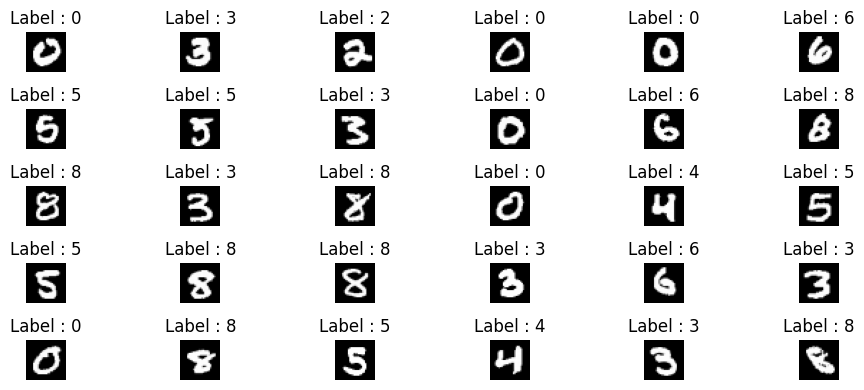

정상 이미지 개수 : 9500



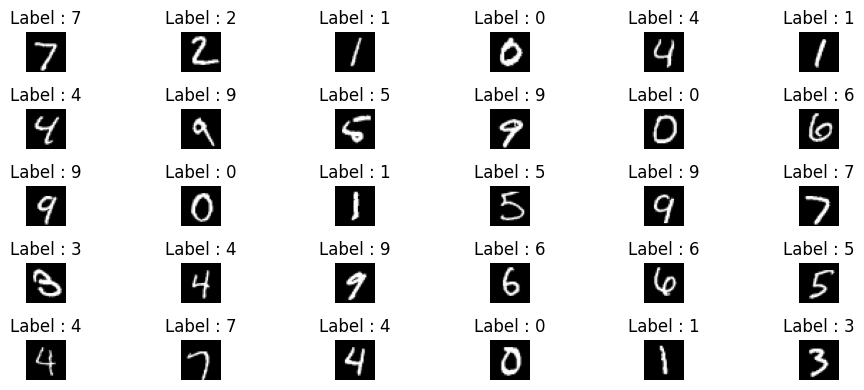

In [ ]:
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_data = test_dataset.data.view(-1, 28*28).numpy()
test_labels = test_dataset.targets.numpy()

# Autoenocder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 모델 초기화 및 학습된 가중치 로드
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder2.pth'))
autoencoder.eval() # 평가 모드

# 테스트 데이터 재구축
test_data_tensor = torch.FloatTensor(test_data) # numpy 배열을 tensor로 변환
with torch.no_grad(): # 기울기 계산 비활성화
    reconstructed_data = autoencoder(test_data_tensor)

# 재구축 오차 계산
reconstruction_error = np.mean((test_data_tensor.numpy() - reconstructed_data.numpy())**2, axis = 1)

# 임계값 설정 (상위 5%)
threshold = np.percentile(reconstruction_error, 95)
outliers = np.where(reconstruction_error > threshold)[0]

# 이상치로 분류된 이미지 개수 출력
num_outliers = len(outliers)
print(f'이상치로 분류된 이미지 개수 : {num_outliers}')
print()

# 이상치 이미지 30개 출력
num_images = min(30, num_outliers)
plt.figure(figsize = (10,4))
for i in range(num_images):
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_data[outliers[i]].reshape(28, 28), cmap = 'gray')
    plt.title(f'Label : {test_labels[outliers[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 정상 이미지 개수 출력
normal_data = np.where(reconstruction_error <= threshold)[0]
num_normal_data = len(normal_data)
print(f'정상 이미지 개수 : {num_normal_data}')
print()

# 정상 이미지 30개 출력
num_normal_images = min(30, num_normal_data)
plt.figure(figsize = (10, 4))
for i in range(num_normal_images):
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_data[normal_data[i]].reshape(28, 28), cmap = 'gray')
    plt.title(f'Label : {test_labels[normal_data[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()